## Estimation of Formation Energy of Materials

In [1]:
!pip install pymatgen==2021.2.8

     |████████████████████████████████| 3.0 MB 286 kB/s            
  Installing build dependencies ... - \ | / - \ | done
  Getting requirements to build wheel ... - \ | / - done
  Installing backend dependencies ... - \ | done
  Preparing metadata (pyproject.toml) ... - \ | / - done
     |████████████████████████████████| 109 kB 57.6 MB/s            
     |████████████████████████████████| 65 kB 2.8 MB/s             
     |████████████████████████████████| 325 kB 64.3 MB/s            
     |████████████████████████████████| 98 kB 5.5 MB/s             
     |████████████████████████████████| 546 kB 64.9 MB/s            
  Created wheel for pymatgen: filename=pymatgen-2021.2.8-cp37-cp37m-linux_x86_64.whl size=4193660 sha256=65aa6e3e32e22d7c727d6a201feaf3d563a202b36df741c25a0e4b24d07340b0
  Stored in directory: /root/.cache/pip/wheels/18/b8/b1/be858f690fff99b56dbf15f7ca3683d443996771550c9b3188
Successfully built pymatgen


In [2]:
#necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from pymatgen.core.periodic_table import Element
from pymatgen import Composition
from pymatgen import MPRester

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import mean_absolute_error,mean_squared_error,accuracy_score,confusion_matrix

In [3]:
#loading the data
orig_data = pd.read_csv('../input/materials-data/material_data.csv',na_filter=False)
element_data = pd.read_csv('../input/materials-data/element_data.csv',index_col=0)
orig_data.head()

,task_id,formula,formation_energy_per_atom,e_above_hull,band_gap,has_bandstructure
0,mp-1007923,CrNi3,-0.016354,0.000802,0.0,False
1,mp-1008754,TbHg2,-0.069428,0.329909,0.0,True
2,mp-1016886,MgVO3,-2.241438,0.545977,0.0,True
3,mp-1018902,PrSbPt,-1.111238,0.000000,0.0,True
4,mp-1020595,Rb8PO3,-0.772860,0.491666,0.0,True


In [4]:
#materials data information
orig_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124515 entries, 0 to 124514
Data columns (total 6 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   task_id                    124515 non-null  object 
 1   formula                    124515 non-null  object 
 2   formation_energy_per_atom  124515 non-null  float64
 3   e_above_hull               124515 non-null  float64
 4   band_gap                   124515 non-null  float64
 5   has_bandstructure          124515 non-null  bool   
dtypes: bool(1), float64(3), object(2)
memory usage: 4.9+ MB


In [5]:
orig_data.describe()

,formation_energy_per_atom,e_above_hull,band_gap
count,124515.000000,124515.000000,124515.000000
mean,-1.410472,0.148873,1.075733
std,1.211580,0.420030,1.525219
min,-4.618361,0.000000,0.000000
25%,-2.408562,0.000000,0.000000
50%,-1.438384,0.030278,0.110600
75%,-0.459684,0.101252,1.900000
max,5.355523,6.369051,17.902300


In [6]:
element_data.head()

,AtomicRadius,AtomicVolume,AtomicWeight,BulkModulus,BoilingT,Column,CovalentRadius,Density,ElectronAffinity,Electronegativity,FirstIonizationEnergy,HeatCapacityMass,Row,phi,SecondIonizationEnergy,ShearModulus
Element,,,,,,,,,,,,,,,,
H,0.25,18618.051940,1.007940,NaN,20.13,1,31,0.0899,72.8,2.20,13.598443,14.304,1,5.20,NaN,NaN
He,NaN,37236.035560,4.002602,NaN,4.07,18,28,0.1785,0.0,NaN,24.587387,5.130,1,NaN,54.41776,NaN
Li,1.45,21.544058,6.941000,11.0,1615.00,1,128,535.0000,59.6,0.98,5.391719,3.582,2,2.85,75.64000,4.2
Be,1.05,8.098176,9.012182,130.0,2743.00,2,96,1848.0000,0.0,1.57,9.322700,1.825,2,5.05,18.21114,132.0
B,0.85,7.297767,10.811000,320.0,4273.00,13,84,2460.0000,26.7,2.04,8.298020,1.026,2,5.30,25.15480,NaN


In [7]:
#element data information
element_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95 entries, H to Am
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   AtomicRadius            88 non-null     float64
 1   AtomicVolume            93 non-null     float64
 2   AtomicWeight            95 non-null     float64
 3   BulkModulus             69 non-null     float64
 4   BoilingT                93 non-null     float64
 5   Column                  95 non-null     int64  
 6   CovalentRadius          95 non-null     int64  
 7   Density                 93 non-null     float64
 8   ElectronAffinity        86 non-null     float64
 9   Electronegativity       91 non-null     float64
 10  FirstIonizationEnergy   94 non-null     float64
 11  HeatCapacityMass        85 non-null     float64
 12  Row                     95 non-null     int64  
 13  phi                     73 non-null     float64
 14  SecondIonizationEnergy  83 non-null     float64
 

In [8]:
#fillning nan values of elements with mean
element_data.fillna(element_data.mean(),inplace=True)

In [9]:
#max number of elements in a single structure
els = orig_data['formula'].apply(lambda x: len(Composition(x).elements))
max_el = max(els)
print(max_el)

9


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'No. of Elements in Single Structure')

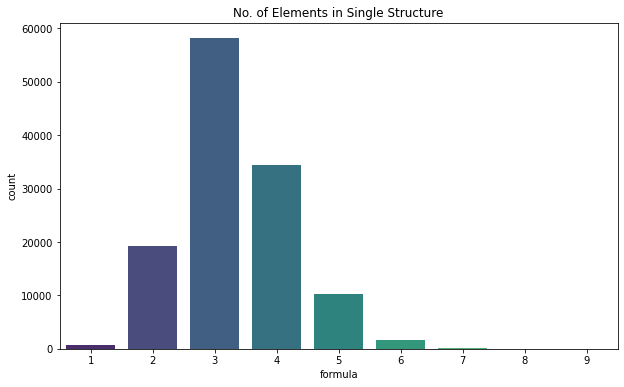

In [10]:
#countplot of no. of elements in a single strucutre
plt.figure(figsize=(10,6))
sns.countplot(els,palette='viridis')
plt.title('No. of Elements in Single Structure')

In [11]:
#breaking down the lements in formula
def composition(df,col_name):    
    df['Elements_in_formula'] = df[col_name].apply(lambda x: Composition(x).elements)
    return df

orig_data = composition(orig_data,'formula')

In [12]:
#num of compounds having noble elements
def no_noble_gas_else(df,col_name):
    cnt=0
    for elements in df[col_name]:
        for element in elements:
            if Element(str(element)).group==18:
                cnt+=1
    return cnt
no_noble_gas_else(orig_data,'Elements_in_formula')

173

In [13]:
#to find noble and non noble gaseous materials
elements_temp=[Element.from_Z(i) for i in range(1,95)]
noble_gases=[i for i in elements_temp if i.is_noble_gas]
def is_contain_noble_gas(elements):
    return any([i in noble_gases for i in elements])
not_contain_noble_gas=[not is_contain_noble_gas(i) for i in orig_data['Elements_in_formula']]

#removing the materials with noble gases
data=orig_data.copy()
data=data[not_contain_noble_gas]
print("The remaining number of materials is %d"%data.shape[0])

The remaining number of materials is 124342


In [14]:
#adding new compositon column to the data
data['composition']=[Composition(i).to_data_dict['unit_cell_composition'] for i in data['formula']]

In [15]:
#to get unit cell composition
def composition_to_dict(c):
    if isinstance(c,dict):
        unit_cell_composition = c
    else:
        if isinstance(c,str):
            c = Composition(c)
        unit_cell_composition = c.to_data_dict['unit_cell_composition']
    return unit_cell_composition

In [16]:
#to get average properties
def average_properties(c,prop):
    unit_cell_composition = composition_to_dict(c)
    res = 0
    total = 0
    for j,k in unit_cell_composition.items():
        res+=element_data.loc[j,prop]*k
        total+=k
    return res/total

In [17]:
#calculating average propeties
properties = element_data.columns.tolist()
average_props = []
for prop in properties:
    average_props.append([average_properties(i,prop) for i in data['composition']])
    
average_props = np.array(average_props).T
average_props.shape

(124342, 16)

In [18]:
#to get max and min properties
def get_maxmin_properties(c,prop,mode='max'):
    if mode=='max':
        func = np.max
    elif mode == 'min':
        func = np.min
    unit_cell_composition = composition_to_dict(c)
    res = func([element_data.loc[i,prop] for i in unit_cell_composition])
    return res

In [19]:
#calculating max and min properties
max_properties=[]
min_properties=[]
for prop in properties:
    max_properties.append([get_maxmin_properties(i,prop,mode='max')for i in data['composition']])
    min_properties.append([get_maxmin_properties(i,prop,mode='min')for i in data['composition']])

max_properties=np.array(max_properties).T
min_properties=np.array(min_properties).T
max_properties.shape,min_properties.shape

((124342, 16), (124342, 16))

In [20]:
#features
total_data=np.concatenate([average_props,max_properties, min_properties], axis=1)
total_data.shape

(124342, 48)

In [21]:
#targets
targets=data[['band_gap','formation_energy_per_atom','e_above_hull']]
targets.shape

(124342, 3)

In [22]:
#splitting the data
X_train, X_test, y_train, y_test = train_test_split(total_data,targets,test_size=0.1,random_state=0)

In [23]:
#normalising the data
X_train_mean = np.mean(X_train,axis=0)
X_train_std = np.std(X_train,axis=0)

X_train_norm = (X_train - X_train_mean)/X_train_std
X_test_norm = (X_test - X_train_mean)/X_train_std

### Predicting Formation Energy with Different Models

Text(2, 2, 'MAE =0.395eV\nRMSE =0.566eV')

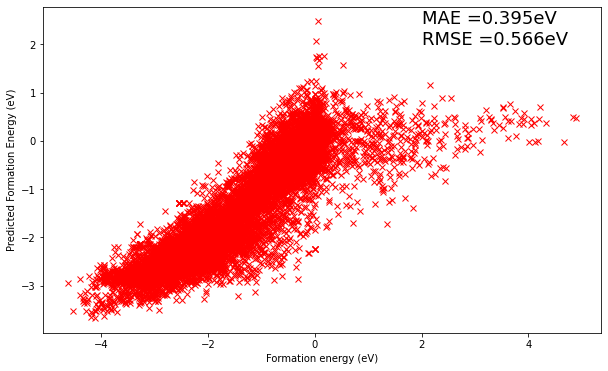

In [24]:
#linear regression
lr = LinearRegression()
lr.fit(X_train_norm,y_train[['formation_energy_per_atom']])

#predictions on test data
lr_preds = lr.predict(X_test_norm)

#mae and rmse
mae_lr = mean_absolute_error(lr_preds,y_test[['formation_energy_per_atom']].values)
rmse_lr = np.sqrt(mean_squared_error(lr_preds,y_test[['formation_energy_per_atom']].values))

#plotting the predictions
plt.figure(figsize=(10,6))
plt.plot(y_test[['formation_energy_per_atom']].values,lr_preds,'rx')
plt.xlabel("Formation energy (eV)")
plt.ylabel("Predicted Formation Energy (eV)")
plt.annotate(f"MAE ={mae_lr:.3f}eV\nRMSE ={rmse_lr:.3f}eV", (2,2), fontsize=18)

Text(2, 2, 'MAE =0.395eV\nRMSE =0.566eV')

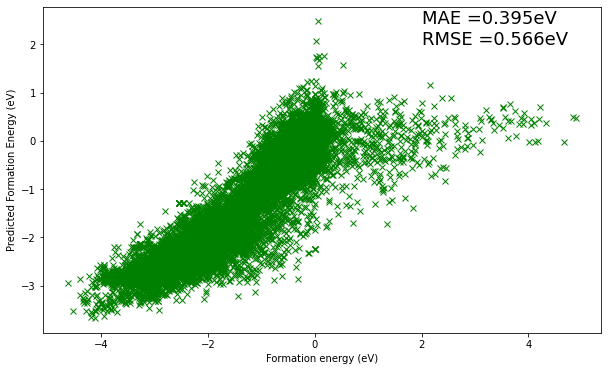

In [25]:
#ridege
ridge = Ridge(alpha=0.1)
ridge.fit(X_train_norm,y_train[['formation_energy_per_atom']])

#predictions on test data
ridge_preds = ridge.predict(X_test_norm)

#mae and rmse
mae_ridge = mean_absolute_error(ridge_preds,y_test[['formation_energy_per_atom']].values)
rmse_ridge = np.sqrt(mean_squared_error(ridge_preds,y_test[['formation_energy_per_atom']].values))

#plotting the predictions
plt.figure(figsize=(10,6))
plt.plot(y_test[['formation_energy_per_atom']].values,ridge_preds,'gx')
plt.xlabel("Formation energy (eV)")
plt.ylabel("Predicted Formation Energy (eV)")
plt.annotate(f"MAE ={mae_ridge:.3f}eV\nRMSE ={rmse_ridge:.3f}eV", (2,2), fontsize=18)

Text(2, 2, 'MAE =0.463eV\nRMSE =0.658eV')

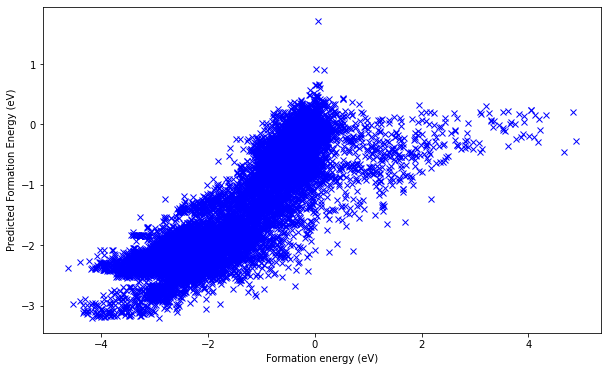

In [26]:
#lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_norm,y_train[['formation_energy_per_atom']])

#predictions on test data
lasso_preds = lasso.predict(X_test_norm)

#mae and rmse
mae_lasso = mean_absolute_error(lasso_preds,y_test[['formation_energy_per_atom']].values)
rmse_lasso = np.sqrt(mean_squared_error(lasso_preds,y_test[['formation_energy_per_atom']].values))

#plotting the predictions
plt.figure(figsize=(10,6))
plt.plot(y_test[['formation_energy_per_atom']].values,lasso_preds,'bx')
plt.xlabel("Formation energy (eV)")
plt.ylabel("Predicted Formation Energy (eV)")
plt.annotate(f"MAE ={mae_lasso:.3f}eV\nRMSE ={rmse_lasso:.3f}eV", (2,2), fontsize=18)

### Predicting whether the material is metallic or non metallic

In [27]:
#let's assume if bandgap is less than 0.001 it's metallic
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

train_bg_label = y_train['band_gap']< 0.001
train_bg_label = le.fit_transform(train_bg_label)

test_bg_label = y_test['band_gap']< 0.001
test_bg_label = le.fit_transform(test_bg_label)

In [28]:
#logistic regresstion
log = LogisticRegression(max_iter=1000)
log.fit(X_train_norm,train_bg_label)

#predictions on test data
log_preds = log.predict(X_test_norm)

#accuracy score
acc = accuracy_score(log_preds,test_bg_label)

#confusion matrix
cm = confusion_matrix(log_preds,test_bg_label)

print('Accuracy Score:',acc*100)
print('Confusion Matrix:\n',cm)

Accuracy Score: 79.61399276236429
Confusion Matrix:
 [[6099 1960]
 [ 575 3801]]
